In [1]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

In [2]:
def showplt(x, y,title, x_name, y_name):
    # Plot the signal
	plt.figure(figsize=(10, 5))
	plt.plot(x, y)
	plt.title(title)
	plt.xlabel(x_name)
	plt.ylabel(y_name)
	plt.grid(True)
	plt.show()

In [3]:
import re
def read_txt():
    with open('data/timemachine.txt', 'r') as f:
        lines = f.readlines()

    # 替换所有非字母字符为空格 去除每行前后空白字符 转换为小写
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_txt()
print(f'Lines = {len(lines)}')
print(lines[0], lines[10],sep='\n')

Lines = 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [4]:
def tokenize(lines, token='word'):
    
    # 按词或英文字符划分词元
    # 以字符串列表形式返回
    if token == 'word':
        # 按空格分割
        return [line.split() for line in lines]
    else:
        # 字符串转为字符列表
        return [list(line) for line in lines]
    
tokens = tokenize(lines, 'word')
tokens[0]    

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']

In [5]:
import collections

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # 如果没有提供词元列表，则使用空列表
        if tokens is None:
            tokens = []
        # 如果没有提供保留词元列表，则使用空列表
        if reserved_tokens is None:
            reserved_tokens = []
        # 统计词元的频率并按频率降序排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 初始化词表，未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 创建从词元到索引的映射字典
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        # 遍历按频率排序后的词元和对应频率
        for token, freq in self._token_freqs:
            # 如果词元的频率小于最小频率，则停止添加
            if freq < min_freq:
                break
            # 如果词元不在词表中，则将其添加到词表并更新映射字典
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        # 返回词表的长度
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        # 如果输入的是单个词元，返回其对应的索引
        if not isinstance(tokens, (list, tuple)): #不是列表或元组
            return self.token_to_idx.get(tokens, self.unk) # 字典中不存则自动返回unk
        # 如果输入的是一个词元列表，递归获取每个词元的索引
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        # 如果输入的是单个索引，返回其对应的词元
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        # 如果输入的是一个索引列表，递归获取每个索引对应的词元
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        # 返回未知词元的索引
        return 0

    @property
    def token_freqs(self):
        # 返回词元及其对应频率的列表
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将2D词元列表展平成一个1D列表
        tokens = [token for line in tokens for token in line]
    # 使用collections.Counter统计词元的频率
    return collections.Counter(tokens)


In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [7]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])
    
'''
文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]
'''

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


"\n文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']\n索引: [1, 19, 50, 40, 2183, 2184, 400]\n文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']\n索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]\n"

In [8]:
def load_corpus(max_tokens=-1):  

    lines = read_txt()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)

    # for line in tokens 枚举tokens中的每一行
    # for token in line 枚举line中的每个词元
    # 按顺序合并成一个列表 词元 -> 此表索引
    corpus = [vocab[token] for line in tokens for token in line]
    
    if max_tokens > 0: # 最多保留数量
        corpus = corpus[:max_tokens] 
        
    return corpus, vocab

corpus, vocab = load_corpus()
len(corpus), len(vocab)


(170580, 28)

Text(0, 0.5, 'Frequency (log scale)')

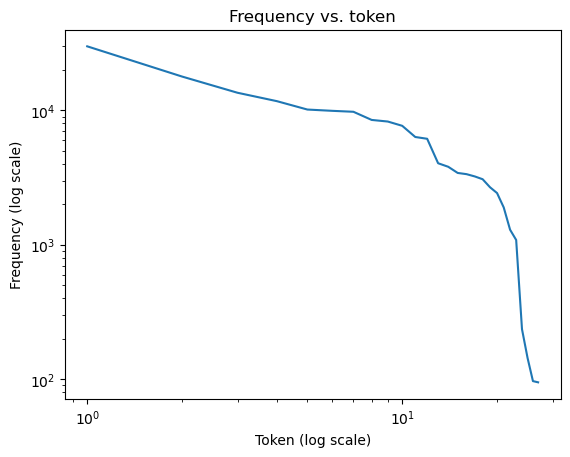

In [9]:
freq = [freq for token, freq in vocab.token_freqs]
indices = np.arange(1, len(freq) + 1)
plt.figure()
plt.plot(indices, freq)
plt.xscale('log')
plt.yscale('log')
plt.title('Frequency vs. token')
plt.xlabel('Token (log scale)')
plt.ylabel('Frequency (log scale)')


In [10]:
import random
def seq_data_iter_random(corpus, batch_size, subseq_len):  

	# 随机偏移 一个subseq长度以内的量
    corpus = corpus[random.randint(0, subseq_len - 1):]

	# 实际能够生成的subseq数量
    num_subseqs = (len(corpus) - 1) // subseq_len
    
	
	# 长度为subseq_len的子序列的起始索引
    # [0, len, len*2, len*3, ...]
    initial_indices = list(range(0, num_subseqs * subseq_len, subseq_len))
    # 打乱位置 保证随机性
    random.shuffle(initial_indices)

    # 分配到各个batch中
    num_batches = num_subseqs // batch_size

    for i in range(0, batch_size * num_batches, batch_size):
        
        # [i, i + batch_size - 1]的索引为这个batch所有序列的起始坐标
        # 剪出来
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        
        # 剪切出这一部分的序列
        X = [corpus[j: j + subseq_len] for j in initial_indices_per_batch]
        # 偏移一位 作为标签序列
        Y = [corpus[j + 1: j + 1 + subseq_len] for j in initial_indices_per_batch]

        # 提供迭代对象 
        yield torch.tensor(X), torch.tensor(Y)
    
def seq_data_iter_sequential(corpus, batch_size, subseq_len):  #@save

    # 从随机偏移量开始划分序列
    offset = random.randint(0, subseq_len)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    
    # 裁掉前面的偏移 与尾部的多余部分
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])

    # 按batch_size进行reshape 
    # [ [a1, a2, a3], [b1, b2, b3] ]
    # 返回[ [a1], [b1] ], [ [a2], [b2] ], [ [a3], [b3] ]
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    
    num_batches = Xs.shape[1] // subseq_len
    for i in range(0, subseq_len * num_batches, subseq_len):
        X = Xs[:, i: i + subseq_len]
        Y = Ys[:, i: i + subseq_len]
        yield X, Y

my_seq = list(range(35)) # [0,1,2,3...,34]

# 每个子序列的长度为5 每个batch含2个数据

# print('random_solution')
# for X, Y in seq_data_iter_random(my_seq, batch_size=2, subseq_len=5):
#     print('batch:\n')
#     print('X: ', X, '\nY:', Y)

print('sequential_solution')
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, subseq_len=5):
    print('batch:\n')
    print('X: ', X, '\nY:', Y)

sequential_solution
batch:

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
batch:

X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
batch:

X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [11]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps, 
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [12]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [13]:
input_size = 100   # 输入数据编码的维度
hidden_size = 20   # 隐含层维度
num_layers = 4     # 隐含层层数

rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers)

seq_len = 10        # 句子长度
batch_size = 2      

x = torch.randn(seq_len,batch_size, input_size) 
h0 = torch.zeros(num_layers, batch_size, hidden_size)

out, h = rnn(x,h0)

h.shape

torch.Size([4, 2, 20])

In [14]:
class RNNModel(nn.Module):
    def __init__(self, vocab, **kwargs):
        
        super(RNNModel, self).__init__(**kwargs)
        
        self.vocab_size = len(vocab)
        self.num_hiddens = 256
    
        self.rnn = nn.GRU( # 唯一区别 ############
            input_size = self.vocab_size, # 输入数据的维度（28种字符）
            hidden_size = self.num_hiddens,  # 隐藏层维度
            num_layers = 2  # 隐藏层层数
        )
        
        # 输出层 由rnn的隐藏层 预测-> 每一个vocab的概率
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        # self.relu = nn.ReLU()
        
    def forward(self, inputs, state):
        
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # Y = self.relu(Y)
        output = self.linear(Y.reshape(-1, Y.shape[-1]))
        return output, state       
    
    def begin_state(self, batch_size, device):
        return  torch.zeros(
                (self.rnn.num_layers, batch_size, self.num_hiddens),
                device=device
            )

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = RNNModel(vocab).to(device)


In [16]:
def predict(prefix,num_preds = 30):
    
    
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]

    for y in prefix[1:]:  # 预热期
        _, state = net( torch.tensor([outputs[-1]]).reshape(1,1).to(device), state)
        outputs.append(vocab[y])

    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(torch.tensor([outputs[-1]]).reshape(1,1).to(device), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
    
predict('time travel',100)

'time travelqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq'

In [17]:
num_epochs, lr = 1000, 1


In [18]:
import math
import time

def grad_clipping(net, theta):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
            
def train_epoch(net, train_iter, loss, updater, device):

    start = time.time()
    training_loss, tokens = 0.0, 0

    for X, Y in train_iter:
        
        state = net.begin_state(batch_size=X.shape[0], device=device)
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        
        l = loss(y_hat, y.long()).mean()
        
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        updater.step()

        training_loss += l * y.numel()
        tokens += y.numel()

    return math.exp(training_loss / tokens), tokens / (time.time() - start)

time travellere aatee aatee aatee aatee aate
epoch = 20/1000 perplexity 15.6
time travellere the the the the the the the 
epoch = 40/1000 perplexity 11.5
time travellerererererererererererererererer
epoch = 60/1000 perplexity 10.0
time traveller the the the the the the the t
epoch = 80/1000 perplexity 8.7
time traveller the the the the the the the t
epoch = 100/1000 perplexity 8.0
time traveller the time travell the time tra
epoch = 120/1000 perplexity 7.1
time traveller the time and the time and the
epoch = 140/1000 perplexity 6.4
time traveller the the man and and the the m
epoch = 160/1000 perplexity 5.4
time traveller thing time traveller thing ti
epoch = 180/1000 perplexity 4.3
time travellerit to the gravellerit is time 
epoch = 200/1000 perplexity 3.3
time travellerit to three dimensions of spac
epoch = 220/1000 perplexity 2.5
time traveller s soled than a small scace th
epoch = 240/1000 perplexity 2.0
time traveller came back andfilby s anecdote
epoch = 260/1000 perplexity 1.7


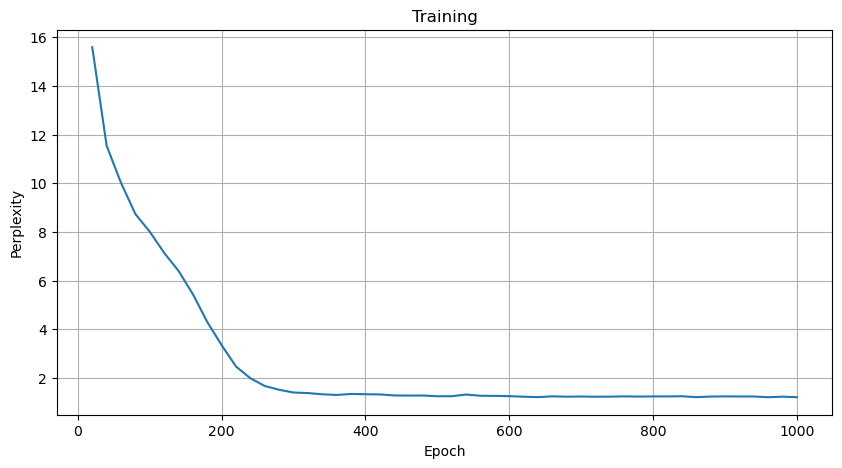

In [19]:
def train(net, train_iter, vocab, lr, num_epochs, device):

    pltx = []
    plty = []
    
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr)

    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device)
        
        if (epoch + 1) % 20 == 0:
            print(predict('time traveller'))
            print(f'epoch = {epoch+1}/{num_epochs} perplexity {ppl:.1f}')
            pltx.append(epoch + 1)
            plty.append(ppl)
            
            
    print('ending')
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
    
    showplt(pltx, plty, 'Training', 'Epoch', 'Perplexity')
train(net, train_iter, vocab, lr, num_epochs, device)

In [20]:
print(predict('time traveller', 200))

time traveller after the pauserequired for the proper assimilation of this know very well thattime is only a kind of space here is a popular scientific diagrama weather record this line i traveller after the pauser


In [21]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 10).shape

torch.Size([5, 2, 10])